# 06. Stacking 앙상블: 하이브리드 통합 모델

Phase 3: 모델 개발 - Stacking 통합

## 목표
- Model 1: **Stacking Classifier** (상승 확률 예측)
  - Base: RandomForest, XGBoost, LightGBM
  - Meta: LogisticRegression
- Model 2: **Stacking Regressor** (상승 시 종가 수익률 예측)
  - Base: RandomForest, XGBoost, LightGBM
  - Meta: Ridge
- **Model 2-1 (신규)**: **Stacking Regressor** (상승 시 고가 수익률 예측, 익절 전략용)
  - Base: RandomForest, XGBoost, LightGBM
  - Meta: Ridge
- Model 3: **Stacking Regressor** (하락 시 손실률 예측)
  - Base: RandomForest, XGBoost, LightGBM
  - Meta: Ridge
- **통합 시스템**: 기대 수익률 계산 및 평가

## 1. 라이브러리 임포트 및 환경 설정

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 루트 경로 추가
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

# Scikit-learn
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    # 분류
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    # 회귀
    mean_absolute_error, mean_squared_error, r2_score
)

# XGBoost, LightGBM
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    print("⚠ XGBoost가 설치되지 않았습니다.")
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    print("⚠ LightGBM이 설치되지 않았습니다.")
    HAS_LGB = False

# 그래프 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

print("✓ 라이브러리 임포트 완료")
print(f"  - XGBoost: {'사용 가능' if HAS_XGB else '사용 불가'}")
print(f"  - LightGBM: {'사용 가능' if HAS_LGB else '사용 불가'}")

✓ 라이브러리 임포트 완료
  - XGBoost: 사용 가능
  - LightGBM: 사용 가능


## 2. 데이터 로드 및 전처리

In [2]:
# 전처리된 데이터 로드
data_path = "/Users/admin/git/study/stock_predict/data/processed/preprocessed_df_full_outlier_fix.parquet"

print(f"데이터 로드 중: {data_path}")
df = pd.read_parquet(data_path)

print(f"\n✓ 데이터 로드 완료")
print(f"  - Shape: {df.shape}")
print(f"  - 날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
print(f"  - 종목 수: {df['InfoCode'].nunique():,}")

데이터 로드 중: /Users/admin/git/study/stock_predict/data/processed/preprocessed_df_full_outlier_fix.parquet

✓ 데이터 로드 완료
  - Shape: (88699, 68)
  - 날짜 범위: 2006-01-17 00:00:00 ~ 2026-01-08 00:00:00
  - 종목 수: 2,225


### 2.1 Feature 선택 및 전처리

In [3]:
# Feature 정의 (입력 변수)
feature_cols = [
    'gap_pct', 'prev_return', 'prev_range_pct', 'prev_upper_shadow', 'prev_lower_shadow',
    'volume_ratio', 'rsi_14', 'atr_14', 'atr_ratio', 'bollinger_position',
    'return_5d', 'return_20d', 'consecutive_up_days',
    'above_ma5', 'above_ma20', 'above_ma50', 'ma5_ma20_cross',
    'market_gap_diff', 'day_of_week', 'month', 'is_month_start', 'is_month_end', 'is_quarter_end',
]

available_features = [f for f in feature_cols if f in df.columns]
print(f"사용 가능한 Features: {len(available_features)}개")

# 타겟 변수 (예측할 값)
target_direction = 'target_direction'
target_return = 'target_return'
target_max_return = 'target_max_return'  # ✅ Model 2-1용

# 핵심 컬럼 (NaN이 있으면 안 되는 필수 컬럼)
required_cols = list(dict.fromkeys(
    available_features + 
    [target_direction, target_return, target_max_return, 'date', 'InfoCode']  # ✅ target_max_return 추가
))
core_features = ['gap_pct', 'prev_return', 'market_gap_diff', target_direction, target_return]

# NaN 처리
df_model = df[required_cols].drop_duplicates().copy()
df_model = df_model.dropna(subset=[c for c in core_features if c in df_model.columns])

# 나머지 Features fillna
for col in available_features:
    if col not in core_features and col in df_model.columns:
        if df_model[col].isna().sum() > 0:
            if df_model[col].dtype in ['float64', 'int64']:
                df_model[col] = df_model[col].fillna(df_model[col].median())
            else:
                df_model[col] = df_model[col].fillna(0)

print(f"\n최종 데이터: {len(df_model):,}개")
print(f"✅ 전처리 완료")
print(f"✅ target_max_return 포함: {target_max_return in df_model.columns}")

사용 가능한 Features: 23개

최종 데이터: 87,925개
✅ 전처리 완료
✅ target_max_return 포함: True


### 2.2 데이터 분할 (전체 / 상승 / 하락)

In [4]:
# 전체 데이터 분할 (Model 1용)
X_all = df_model[available_features]
y_direction = df_model[target_direction]
y_return = df_model[target_return]

# Train+Valid와 Test 분할 (90:10)
X_temp, X_test, y_dir_temp, y_dir_test, y_ret_temp, y_ret_test = train_test_split(
    X_all, y_direction, y_return, test_size=0.1, random_state=42, stratify=y_direction
)

# Train과 Valid 분할 (80:10)
X_train, X_valid, y_dir_train, y_dir_valid, y_ret_train, y_ret_valid = train_test_split(
    X_temp, y_dir_temp, y_ret_temp, test_size=0.1111, random_state=42, stratify=y_dir_temp
)

print("=" * 80)
print("전체 데이터 분할 (Model 1: Stacking Classifier)")
print("=" * 80)
print(f"Train: {len(X_train):,} ({len(X_train)/len(X_all)*100:.1f}%)")
print(f"Valid: {len(X_valid):,} ({len(X_valid)/len(X_all)*100:.1f}%)")
print(f"Test:  {len(X_test):,} ({len(X_test)/len(X_all)*100:.1f}%)")

# 상승 케이스 데이터 (Model 2용)
df_up = df_model[df_model[target_direction] == 1].copy()
X_up = df_up[available_features]
y_up = df_up[target_return]

X_up_temp, X_up_test, y_up_temp, y_up_test = train_test_split(
    X_up, y_up, test_size=0.1, random_state=42
)
X_up_train, X_up_valid, y_up_train, y_up_valid = train_test_split(
    X_up_temp, y_up_temp, test_size=0.1111, random_state=42
)

print("\n" + "=" * 80)
print("상승 케이스 분할 (Model 2: Stacking Regressor)")
print("=" * 80)
print(f"Train: {len(X_up_train):,} ({len(X_up_train)/len(X_up)*100:.1f}%)")
print(f"Valid: {len(X_up_valid):,} ({len(X_up_valid)/len(X_up)*100:.1f}%)")
print(f"Test:  {len(X_up_test):,} ({len(X_up_test)/len(X_up)*100:.1f}%)")
print(f"평균 수익률: {y_up_train.mean():.2f}%")

# 하락 케이스 데이터 (Model 3용)
df_down = df_model[df_model[target_direction] == 0].copy()
X_down = df_down[available_features]
y_down = df_down[target_return]

X_down_temp, X_down_test, y_down_temp, y_down_test = train_test_split(
    X_down, y_down, test_size=0.1, random_state=42
)
X_down_train, X_down_valid, y_down_train, y_down_valid = train_test_split(
    X_down_temp, y_down_temp, test_size=0.1111, random_state=42
)

print("\n" + "=" * 80)
print("하락 케이스 분할 (Model 3: Stacking Regressor)")
print("=" * 80)
print(f"Train: {len(X_down_train):,} ({len(X_down_train)/len(X_down)*100:.1f}%)")
print(f"Valid: {len(X_down_valid):,} ({len(X_down_valid)/len(X_down)*100:.1f}%)")
print(f"Test:  {len(X_down_test):,} ({len(X_down_test)/len(X_down)*100:.1f}%)")
print(f"평균 손실률: {y_down_train.mean():.2f}%")

print("\n✅ 데이터 분할 완료")

전체 데이터 분할 (Model 1: Stacking Classifier)
Train: 70,340 (80.0%)
Valid: 8,792 (10.0%)
Test:  8,793 (10.0%)

상승 케이스 분할 (Model 2: Stacking Regressor)
Train: 19,978 (80.0%)
Valid: 2,498 (10.0%)
Test:  2,498 (10.0%)
평균 수익률: 4.29%

하락 케이스 분할 (Model 3: Stacking Regressor)
Train: 50,360 (80.0%)
Valid: 6,295 (10.0%)
Test:  6,296 (10.0%)
평균 손실률: -4.16%

✅ 데이터 분할 완료


In [5]:
# Model 2-1용 데이터 준비 (고가 예측)
target_max_col = 'target_max_return'

if target_max_col in df_model.columns:
    print("\n" + "=" * 80)
    print("Model 2-1용 데이터 분할 (Stacking Regressor - 고가)")
    print("=" * 80)
    
    # 상승 케이스의 고가 수익률
    y_up_max = df_up[target_max_col]
    
    # 동일한 split 사용
    _, _, _, _, _, y_up_max_test = train_test_split(
        X_up, y_up_max, y_direction[df_up.index], test_size=0.1, random_state=42, stratify=y_direction[df_up.index]
    )
    
    X_up_max_temp, y_up_max_temp = X_up_temp, y_up_max.loc[X_up_temp.index]
    X_up_max_train, X_up_max_valid, y_up_max_train, y_up_max_valid = train_test_split(
        X_up_max_temp, y_up_max_temp, test_size=0.1111, random_state=42
    )
    
    print(f"Train: {len(X_up_max_train):,} ({len(X_up_max_train)/len(X_up)*100:.1f}%)")
    print(f"Valid: {len(X_up_max_valid):,} ({len(X_up_max_valid)/len(X_up)*100:.1f}%)")
    print(f"Test:  {len(y_up_max_test):,} ({len(y_up_max_test)/len(X_up)*100:.1f}%)")
    print(f"평균 고가 수익률: {y_up_max_train.mean():.2f}%")
    
    print(f"\n비교:")
    print(f"  Model 2 (종가): 평균 {y_up_train.mean():.2f}%")
    print(f"  Model 2-1 (고가): 평균 {y_up_max_train.mean():.2f}% (차이: +{y_up_max_train.mean() - y_up_train.mean():.2f}%p)")
    
    print("\n✅ Model 2-1 데이터 분할 완료")
else:
    print("\n⚠ target_max_return 컬럼 없음, Model 2-1 건너뜀")
    X_up_max_train, X_up_max_valid, y_up_max_train, y_up_max_valid, y_up_max_test = None, None, None, None, None


Model 2-1용 데이터 분할 (Stacking Regressor - 고가)
Train: 19,978 (80.0%)
Valid: 2,498 (10.0%)
Test:  2,498 (10.0%)
평균 고가 수익률: 7.07%

비교:
  Model 2 (종가): 평균 4.29%
  Model 2-1 (고가): 평균 7.07% (차이: +2.78%p)

✅ Model 2-1 데이터 분할 완료


## 3. Model 1: Stacking Classifier (상승 확률 예측)

**구조:**
- Base Learners: RandomForest, XGBoost, LightGBM
- Meta Learner: LogisticRegression
- CV: 5-fold

In [6]:
print("=" * 80)
print("Model 1: Stacking Classifier 학습")
print("=" * 80)

# Base learners 정의
base_classifiers = [
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )),
]

if HAS_XGB:
    # XGBoost에서 class_weight 대신 scale_pos_weight 사용
    n_neg = (y_dir_train == 0).sum()
    n_pos = (y_dir_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    
    base_classifiers.append(
        ('xgb', xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ))
    )

if HAS_LGB:
    base_classifiers.append(
        ('lgb', lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=15,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ))
    )

print(f"\nBase Learners ({len(base_classifiers)}개):")
for name, _ in base_classifiers:
    print(f"  - {name.upper()}")

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\n학습 시작...")
import time
start = time.time()

stacking_clf.fit(X_train, y_dir_train)

elapsed = time.time() - start
print(f"\n✓ 학습 완료 (소요 시간: {elapsed:.1f}초)")

Model 1: Stacking Classifier 학습

Base Learners (3개):
  - RF
  - XGB
  - LGB

학습 시작...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.2s remaining:   43.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s finished



✓ 학습 완료 (소요 시간: 36.4초)


### 3.1 Model 1 성능 평가

In [7]:
# 예측
y_train_pred_clf = stacking_clf.predict(X_train)
y_valid_pred_clf = stacking_clf.predict(X_valid)
y_test_pred_clf = stacking_clf.predict(X_test)

y_train_proba_clf = stacking_clf.predict_proba(X_train)[:, 1]
y_valid_proba_clf = stacking_clf.predict_proba(X_valid)[:, 1]
y_test_proba_clf = stacking_clf.predict_proba(X_test)[:, 1]

# 평가
train_acc = accuracy_score(y_dir_train, y_train_pred_clf)
valid_acc = accuracy_score(y_dir_valid, y_valid_pred_clf)
test_acc = accuracy_score(y_dir_test, y_test_pred_clf)

train_auc = roc_auc_score(y_dir_train, y_train_proba_clf)
valid_auc = roc_auc_score(y_dir_valid, y_valid_proba_clf)
test_auc = roc_auc_score(y_dir_test, y_test_proba_clf)

print("=" * 80)
print("Model 1: Stacking Classifier 성능")
print("=" * 80)

print(f"\nAccuracy:")
print(f"  Train: {train_acc:.4f}")
print(f"  Valid: {valid_acc:.4f}")
print(f"  Test:  {test_acc:.4f}")

print(f"\nROC AUC:")
print(f"  Train: {train_auc:.4f}")
print(f"  Valid: {valid_auc:.4f}")
print(f"  Test:  {test_auc:.4f}")

print("\nTest Set 분류 리포트:")
print(classification_report(y_dir_test, y_test_pred_clf, target_names=['하락(0)', '상승(1)']))

# 최적 Threshold 적용 (0.4)
optimal_threshold = 0.4
y_test_pred_clf_opt = (y_test_proba_clf >= optimal_threshold).astype(int)

precision_opt = precision_score(y_dir_test, y_test_pred_clf_opt, pos_label=1)
recall_opt = recall_score(y_dir_test, y_test_pred_clf_opt, pos_label=1)
f1_opt = f1_score(y_dir_test, y_test_pred_clf_opt, pos_label=1)

print(f"\n최적 Threshold ({optimal_threshold}) 적용:")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall:    {recall_opt:.4f}")
print(f"  F1-Score:  {f1_opt:.4f}")

Model 1: Stacking Classifier 성능

Accuracy:
  Train: 0.7896
  Valid: 0.7230
  Test:  0.7265

ROC AUC:
  Train: 0.9139
  Valid: 0.6329
  Test:  0.6475

Test Set 분류 리포트:
              precision    recall  f1-score   support

       하락(0)       0.73      0.98      0.84      6295
       상승(1)       0.64      0.09      0.15      2498

    accuracy                           0.73      8793
   macro avg       0.68      0.53      0.50      8793
weighted avg       0.70      0.73      0.64      8793


최적 Threshold (0.4) 적용:
  Precision: 0.4802
  Recall:    0.2330
  F1-Score:  0.3137


## 4. Model 2: Stacking Regressor (상승 케이스)

**구조:**
- Base Learners: RandomForest, XGBoost, LightGBM
- Meta Learner: Ridge
- CV: 5-fold

In [8]:
print("=" * 80)
print("Model 2: Stacking Regressor (상승 케이스) 학습")
print("=" * 80)

# Base learners 정의
base_regressors_up = [
    ('rf', RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )),
]

if HAS_XGB:
    base_regressors_up.append(
        ('xgb', xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ))
    )

if HAS_LGB:
    base_regressors_up.append(
        ('lgb', lgb.LGBMRegressor(
            n_estimators=300,
            max_depth=15,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ))
    )

print(f"\nBase Learners ({len(base_regressors_up)}개):")
for name, _ in base_regressors_up:
    print(f"  - {name.upper()}")

# Stacking Regressor
stacking_reg_up = StackingRegressor(
    estimators=base_regressors_up,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\n학습 시작...")
start = time.time()

stacking_reg_up.fit(X_up_train, y_up_train)

elapsed = time.time() - start
print(f"\n✓ 학습 완료 (소요 시간: {elapsed:.1f}초)")

Model 2: Stacking Regressor (상승 케이스) 학습

Base Learners (3개):
  - RF
  - XGB
  - LGB

학습 시작...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.1s remaining:   46.6s



✓ 학습 완료 (소요 시간: 37.4초)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


### 4.1 Model 2 성능 평가

In [9]:
# 예측
y_up_train_pred = stacking_reg_up.predict(X_up_train)
y_up_valid_pred = stacking_reg_up.predict(X_up_valid)
y_up_test_pred = stacking_reg_up.predict(X_up_test)

# 평가
mae_train = mean_absolute_error(y_up_train, y_up_train_pred)
mae_valid = mean_absolute_error(y_up_valid, y_up_valid_pred)
mae_test = mean_absolute_error(y_up_test, y_up_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_up_train, y_up_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_up_valid, y_up_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_up_test, y_up_test_pred))

r2_train = r2_score(y_up_train, y_up_train_pred)
r2_valid = r2_score(y_up_valid, y_up_valid_pred)
r2_test = r2_score(y_up_test, y_up_test_pred)

print("=" * 80)
print("Model 2: Stacking Regressor (상승) 성능")
print("=" * 80)

print(f"\nMAE:")
print(f"  Train: {mae_train:.4f}%")
print(f"  Valid: {mae_valid:.4f}%")
print(f"  Test:  {mae_test:.4f}%")

print(f"\nRMSE:")
print(f"  Train: {rmse_train:.4f}%")
print(f"  Valid: {rmse_valid:.4f}%")
print(f"  Test:  {rmse_test:.4f}%")

print(f"\nR²:")
print(f"  Train: {r2_train:.4f}")
print(f"  Valid: {r2_valid:.4f}")
print(f"  Test:  {r2_test:.4f}")

Model 2: Stacking Regressor (상승) 성능

MAE:
  Train: 1.9975%
  Valid: 2.6509%
  Test:  2.5774%

RMSE:
  Train: 2.4083%
  Valid: 3.1807%
  Test:  3.1189%

R²:
  Train: 0.4657
  Valid: 0.0535
  Test:  0.0669


## 4-B. Model 2-1: Stacking Regressor (상승 시 고가 수익률)

**구조:**
- Base Learners: RandomForest, XGBoost, LightGBM
- Meta Learner: Ridge
- CV: 5-fold

In [10]:
if target_max_col in df_model.columns and y_up_max_train is not None:
    print("=" * 80)
    print("Model 2-1: Stacking Regressor (고가) 학습")
    print("=" * 80)

    y_up_max_test_correct = df_up.loc[X_up_test.index, 'target_max_return']
    y_up_max_train_correct = df_up.loc[X_up_train.index, 'target_max_return']
    y_up_max_valid_correct = df_up.loc[X_up_valid.index, 'target_max_return']

    y_up_max_train = y_up_max_train_correct
    y_up_max_valid = y_up_max_valid_correct
    y_up_max_test = y_up_max_test_correct
    
    # Base learners 정의 (Model 2와 동일)
    base_regressors_up_max = [
        ('rf', RandomForestRegressor(
            n_estimators=300, max_depth=15, min_samples_split=10,
            random_state=42, n_jobs=-1, verbose=0
        )),
    ]
    
    if HAS_XGB:
        base_regressors_up_max.append(
            ('xgb', xgb.XGBRegressor(
                n_estimators=300, max_depth=6, learning_rate=0.1,
                random_state=42, n_jobs=-1, verbosity=0
            ))
        )
    
    if HAS_LGB:
        base_regressors_up_max.append(
            ('lgb', lgb.LGBMRegressor(
                n_estimators=300, max_depth=15, learning_rate=0.1,
                random_state=42, n_jobs=-1, verbosity=-1
            ))
        )
    
    print(f"\nBase Learners ({len(base_regressors_up_max)}개):")
    for name, _ in base_regressors_up_max:
        print(f"  - {name.upper()}")
    
    # Stacking Regressor
    stacking_reg_up_max = StackingRegressor(
        estimators=base_regressors_up_max,
        final_estimator=Ridge(alpha=1.0, random_state=42),
        cv=5,
        n_jobs=-1,
        verbose=1
    )


        
    print("\n학습 시작...")
    start = time.time()
    
    stacking_reg_up_max.fit(X_up_max_train, y_up_max_train)
    
    elapsed = time.time() - start
    print(f"\n✓ 학습 완료 (소요 시간: {elapsed:.1f}초)")
else:
    print("\n⚠ Model 2-1 건너뜀 (target_max_return 없음)")
    stacking_reg_up_max = None

Model 2-1: Stacking Regressor (고가) 학습

Base Learners (3개):
  - RF
  - XGB
  - LGB

학습 시작...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.1s remaining:   46.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished



✓ 학습 완료 (소요 시간: 37.2초)


### 4-B.1 Model 2-1 성능 평가

In [11]:
if stacking_reg_up_max is not None:
    # 예측
    y_up_max_train_pred = stacking_reg_up_max.predict(X_up_max_train)
    y_up_max_valid_pred = stacking_reg_up_max.predict(X_up_max_valid)
    y_up_max_test_pred = stacking_reg_up_max.predict(X_up_test)
    
    # 평가
    mae_train_max = mean_absolute_error(y_up_max_train, y_up_max_train_pred)
    mae_valid_max = mean_absolute_error(y_up_max_valid, y_up_max_valid_pred)
    mae_test_max = mean_absolute_error(y_up_max_test, y_up_max_test_pred)
    
    rmse_train_max = np.sqrt(mean_squared_error(y_up_max_train, y_up_max_train_pred))
    rmse_valid_max = np.sqrt(mean_squared_error(y_up_max_valid, y_up_max_valid_pred))
    rmse_test_max = np.sqrt(mean_squared_error(y_up_max_test, y_up_max_test_pred))
    
    r2_train_max = r2_score(y_up_max_train, y_up_max_train_pred)
    r2_valid_max = r2_score(y_up_max_valid, y_up_max_valid_pred)
    r2_test_max = r2_score(y_up_max_test, y_up_max_test_pred)
    
    print("=" * 80)
    print("Model 2-1: Stacking Regressor (고가) 성능")
    print("=" * 80)
    
    print(f"\nMAE:")
    print(f"  Train: {mae_train_max:.4f}%")
    print(f"  Valid: {mae_valid_max:.4f}%")
    print(f"  Test:  {mae_test_max:.4f}%")
    
    print(f"\nRMSE:")
    print(f"  Train: {rmse_train_max:.4f}%")
    print(f"  Valid: {rmse_valid_max:.4f}%")
    print(f"  Test:  {rmse_test_max:.4f}%")
    
    print(f"\nR²:")
    print(f"  Train: {r2_train_max:.4f}")
    print(f"  Valid: {r2_valid_max:.4f}")
    print(f"  Test:  {r2_test_max:.4f}")
    
    # Model 2 vs 2-1 비교
    print("\n" + "=" * 80)
    print("Model 2 (종가) vs Model 2-1 (고가) 비교")
    print("=" * 80)
    
    mae_test_close = mean_absolute_error(y_up_test, y_up_test_pred)
    print(f"\nModel 2 (종가) Test MAE: {mae_test_close:.4f}%")
    print(f"Model 2-1 (고가) Test MAE: {mae_test_max:.4f}%")
    print(f"차이: {mae_test_max - mae_test_close:+.4f}%p")
    
    print(f"\n평균 수익률:")
    print(f"  종가 (Model 2): {y_up_test.mean():.2f}%")
    print(f"  고가 (Model 2-1): {y_up_max_test.mean():.2f}%")
    print(f"  추가 수익 기회: +{y_up_max_test.mean() - y_up_test.mean():.2f}%p")
else:
    print("⚠ Model 2-1 평가 건너뜀")

Model 2-1: Stacking Regressor (고가) 성능

MAE:
  Train: 1.9291%
  Valid: 2.6274%
  Test:  2.6222%

RMSE:
  Train: 2.3991%
  Valid: 3.2607%
  Test:  3.2789%

R²:
  Train: 0.5235
  Valid: 0.0914
  Test:  0.1216

Model 2 (종가) vs Model 2-1 (고가) 비교

Model 2 (종가) Test MAE: 2.5774%
Model 2-1 (고가) Test MAE: 2.6222%
차이: +0.0448%p

평균 수익률:
  종가 (Model 2): 4.28%
  고가 (Model 2-1): 7.07%
  추가 수익 기회: +2.79%p


## 5. Model 3: Stacking Regressor (하락 케이스)

**구조:**
- Base Learners: RandomForest, XGBoost, LightGBM
- Meta Learner: Ridge
- CV: 5-fold

In [12]:
print("=" * 80)
print("Model 3: Stacking Regressor (하락 케이스) 학습")
print("=" * 80)

# Base learners 정의
base_regressors_down = [
    ('rf', RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )),
]

if HAS_XGB:
    base_regressors_down.append(
        ('xgb', xgb.XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ))
    )

if HAS_LGB:
    base_regressors_down.append(
        ('lgb', lgb.LGBMRegressor(
            n_estimators=300,
            max_depth=15,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ))
    )

print(f"\nBase Learners ({len(base_regressors_down)}개):")
for name, _ in base_regressors_down:
    print(f"  - {name.upper()}")

# Stacking Regressor
stacking_reg_down = StackingRegressor(
    estimators=base_regressors_down,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\n학습 시작...")
start = time.time()

stacking_reg_down.fit(X_down_train, y_down_train)

elapsed = time.time() - start
print(f"\n✓ 학습 완료 (소요 시간: {elapsed:.1f}초)")

Model 3: Stacking Regressor (하락 케이스) 학습

Base Learners (3개):
  - RF
  - XGB
  - LGB

학습 시작...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min



✓ 학습 완료 (소요 시간: 94.3초)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


### 5.1 Model 3 성능 평가

In [13]:
# 예측
y_down_train_pred = stacking_reg_down.predict(X_down_train)
y_down_valid_pred = stacking_reg_down.predict(X_down_valid)
y_down_test_pred = stacking_reg_down.predict(X_down_test)

# 평가
mae_train = mean_absolute_error(y_down_train, y_down_train_pred)
mae_valid = mean_absolute_error(y_down_valid, y_down_valid_pred)
mae_test = mean_absolute_error(y_down_test, y_down_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_down_train, y_down_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_down_valid, y_down_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_down_test, y_down_test_pred))

r2_train = r2_score(y_down_train, y_down_train_pred)
r2_valid = r2_score(y_down_valid, y_down_valid_pred)
r2_test = r2_score(y_down_test, y_down_test_pred)

print("=" * 80)
print("Model 3: Stacking Regressor (하락) 성능")
print("=" * 80)

print(f"\nMAE:")
print(f"  Train: {mae_train:.4f}%")
print(f"  Valid: {mae_valid:.4f}%")
print(f"  Test:  {mae_test:.4f}%")

print(f"\nRMSE:")
print(f"  Train: {rmse_train:.4f}%")
print(f"  Valid: {rmse_valid:.4f}%")
print(f"  Test:  {rmse_test:.4f}%")

print(f"\nR²:")
print(f"  Train: {r2_train:.4f}")
print(f"  Valid: {r2_valid:.4f}")
print(f"  Test:  {r2_test:.4f}")

Model 3: Stacking Regressor (하락) 성능

MAE:
  Train: 1.6183%
  Valid: 1.9405%
  Test:  1.9709%

RMSE:
  Train: 2.1048%
  Valid: 2.5459%
  Test:  2.5825%

R²:
  Train: 0.4535
  Valid: 0.1836
  Test:  0.1916


## 6. 통합 예측 시스템

3개 모델을 결합하여 **기대 수익률** 계산:

```
기대 수익률 = P(상승) × E[상승시] + P(하락) × E[하락시]
```

In [14]:
# 통합 예측 클래스
class StackingHybridPredictor:
    def __init__(self, classifier, regressor_up, regressor_down, threshold=0.4):
        self.classifier = classifier
        self.regressor_up = regressor_up
        self.regressor_down = regressor_down
        self.threshold = threshold
    
    def predict(self, X):
        # 1. 상승 확률
        prob_up = self.classifier.predict_proba(X)[:, 1]
        prob_down = 1 - prob_up
        
        # 2. 상승 시 예상 수익률
        return_if_up = self.regressor_up.predict(X)
        
        # 3. 하락 시 예상 손실률
        return_if_down = self.regressor_down.predict(X)
        
        # 4. 기대 수익률 계산
        expected_return = (prob_up * return_if_up) + (prob_down * return_if_down)
        
        return pd.DataFrame({
            'prob_up': prob_up,
            'prob_down': prob_down,
            'return_if_up': return_if_up,
            'return_if_down': return_if_down,
            'expected_return': expected_return,
            'predicted_direction': (prob_up >= self.threshold).astype(int)
        })

# 통합 예측기 생성
hybrid_predictor = StackingHybridPredictor(
    classifier=stacking_clf,
    regressor_up=stacking_reg_up,
    regressor_down=stacking_reg_down,
    threshold=optimal_threshold
)

print("✓ 통합 예측 시스템 생성 완료")

✓ 통합 예측 시스템 생성 완료


### 6.1 Test Set 통합 예측

In [15]:
# Test Set 예측
predictions = hybrid_predictor.predict(X_test)

# 실제 값 추가
predictions['actual_direction'] = y_dir_test.values
predictions['actual_return'] = y_ret_test.values

print("=" * 80)
print("통합 예측 결과 (Test Set)")
print("=" * 80)

print("\n예측 샘플 (처음 10개):")
print(predictions.head(10).to_string())

print("\n통계:")
print(predictions[['prob_up', 'return_if_up', 'return_if_down', 'expected_return', 'actual_return']].describe())

통합 예측 결과 (Test Set)

예측 샘플 (처음 10개):
    prob_up  prob_down  return_if_up  return_if_down  expected_return  predicted_direction  actual_direction  actual_return
0  0.250230   0.749770      4.248889       -2.797444        -1.034237                    0                 0      -3.928571
1  0.284874   0.715126      2.841058       -3.550546        -1.729744                    0                 1       1.092896
2  0.165805   0.834195      3.593446       -2.434807        -1.435292                    0                 0      -0.738007
3  0.316922   0.683078      3.450075       -2.648404        -0.715662                    0                 1       2.283105
4  0.406470   0.593530      6.025656       -3.342568         0.465332                    1                 1      11.206897
5  0.347475   0.652525      4.199775       -2.899731        -0.432831                    0                 1       7.142857
6  0.228377   0.771623      3.491159       -2.223398        -0.918327                    0     

방향 예측 정확도

Accuracy: 0.7105

분류 리포트:
              precision    recall  f1-score   support

       하락(0)       0.75      0.90      0.82      6295
       상승(1)       0.48      0.23      0.31      2498

    accuracy                           0.71      8793
   macro avg       0.61      0.57      0.57      8793
weighted avg       0.67      0.71      0.67      8793


혼동 행렬:
[[5665  630]
 [1916  582]]


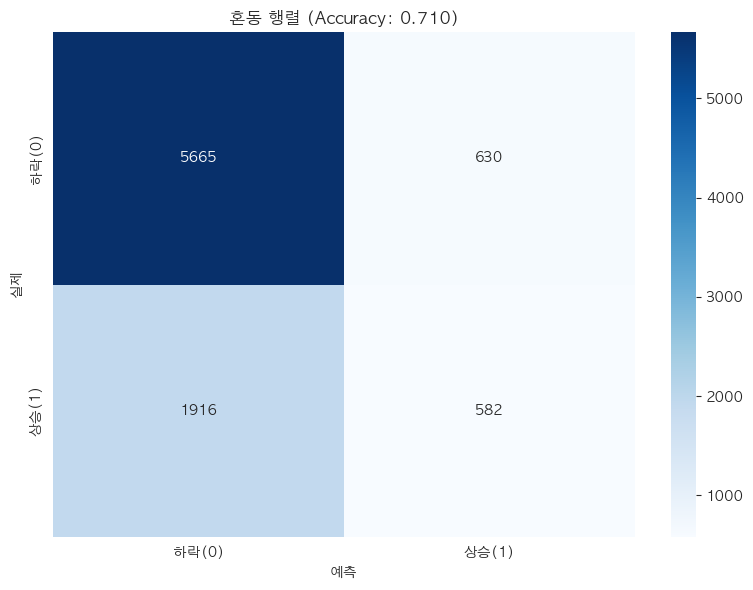

In [16]:
# 방향 예측 정확도
direction_acc = accuracy_score(predictions['actual_direction'], predictions['predicted_direction'])

print("=" * 80)
print("방향 예측 정확도")
print("=" * 80)

print(f"\nAccuracy: {direction_acc:.4f}")

print("\n분류 리포트:")
print(classification_report(predictions['actual_direction'], 
                          predictions['predicted_direction'], 
                          target_names=['하락(0)', '상승(1)']))

# 혼동 행렬
cm = confusion_matrix(predictions['actual_direction'], predictions['predicted_direction'])
print("\n혼동 행렬:")
print(cm)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['하락(0)', '상승(1)'],
            yticklabels=['하락(0)', '상승(1)'])
plt.xlabel('예측')
plt.ylabel('실제')
plt.title(f'혼동 행렬 (Accuracy: {direction_acc:.3f})')
plt.tight_layout()
plt.show()

기대 수익률 vs 실제 수익률

상관계수: 0.3981
MAE: 3.4009%

기대 수익률 분위수별 실제 평균:
                   expected_return  actual_return  prob_up
expected_quintile                                         
Q1                         -3.6286        -4.6695   0.1927
Q2                         -2.3114        -2.2697   0.2301
Q3                         -1.6573        -1.5665   0.2660
Q4                         -1.0486        -0.8492   0.3153
Q5                          0.0719         0.5998   0.4365


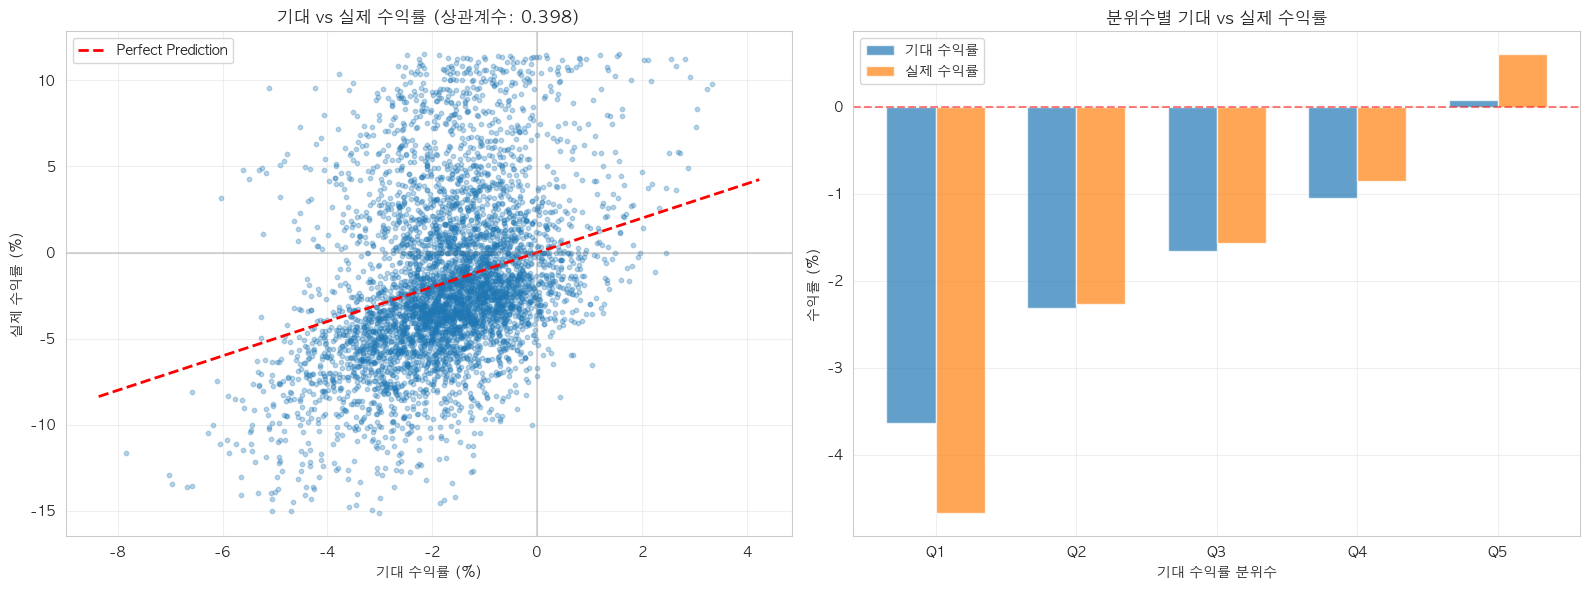

In [17]:
# 기대 수익률과 실제 수익률 상관관계
correlation = predictions['expected_return'].corr(predictions['actual_return'])

print("=" * 80)
print("기대 수익률 vs 실제 수익률")
print("=" * 80)

print(f"\n상관계수: {correlation:.4f}")

# MAE
mae = mean_absolute_error(predictions['actual_return'], predictions['expected_return'])
print(f"MAE: {mae:.4f}%")

# 기대 수익률 분위수별 실제 평균 수익률
predictions['expected_quintile'] = pd.qcut(predictions['expected_return'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

quintile_analysis = predictions.groupby('expected_quintile').agg({
    'expected_return': 'mean',
    'actual_return': 'mean',
    'prob_up': 'mean'
}).round(4)

print("\n기대 수익률 분위수별 실제 평균:")
print(quintile_analysis)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 산점도
sample_idx = np.random.choice(len(predictions), min(5000, len(predictions)), replace=False)
axes[0].scatter(predictions.iloc[sample_idx]['expected_return'], 
                predictions.iloc[sample_idx]['actual_return'], 
                alpha=0.3, s=10)
axes[0].plot([predictions['expected_return'].min(), predictions['expected_return'].max()],
             [predictions['expected_return'].min(), predictions['expected_return'].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(0, color='gray', linestyle='-', alpha=0.3)
axes[0].set_xlabel('기대 수익률 (%)')
axes[0].set_ylabel('실제 수익률 (%)')
axes[0].set_title(f'기대 vs 실제 수익률 (상관계수: {correlation:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 분위수별 비교
x_pos = range(len(quintile_analysis))
width = 0.35
axes[1].bar([p - width/2 for p in x_pos], quintile_analysis['expected_return'], 
            width, label='기대 수익률', alpha=0.7)
axes[1].bar([p + width/2 for p in x_pos], quintile_analysis['actual_return'], 
            width, label='실제 수익률', alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('기대 수익률 분위수')
axes[1].set_ylabel('수익률 (%)')
axes[1].set_title('분위수별 기대 vs 실제 수익률')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(quintile_analysis.index)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 모델 저장

In [18]:
# 모델 저장 경로
model_dir = Path("../models/stacking")
model_dir.mkdir(parents=True, exist_ok=True)

# 통합 시스템 저장
stacking_model_path = model_dir / "stacking_hybrid_model.pkl"
stacking_metadata = {
    'hybrid_predictor': hybrid_predictor,
    'stacking_clf': stacking_clf,
    'stacking_reg_up': stacking_reg_up,
    'stacking_reg_up_max': stacking_reg_up_max if stacking_reg_up_max is not None else None,
    'stacking_reg_down': stacking_reg_down,
    'features': available_features,
    'optimal_threshold': optimal_threshold,
    'test_metrics': {
        'classifier': {
            'accuracy': test_acc,
            'roc_auc': test_auc,
            'precision': precision_opt,
            'recall': recall_opt,
            'f1_score': f1_opt,
        },
        'regressor_up': {
            'mae': mean_absolute_error(y_up_test, y_up_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_up_test, y_up_test_pred)),
            'r2': r2_score(y_up_test, y_up_test_pred),
        },
        'regressor_up_max': {
            'mae': mae_test_max if stacking_reg_up_max is not None else None,
            'rmse': rmse_test_max if stacking_reg_up_max is not None else None,
            'r2': r2_test_max if stacking_reg_up_max is not None else None,
        } if stacking_reg_up_max is not None else None,
        'regressor_down': {
            'mae': mean_absolute_error(y_down_test, y_down_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_down_test, y_down_test_pred)),
            'r2': r2_score(y_down_test, y_down_test_pred),
        },
        'integrated': {
            'direction_accuracy': direction_acc,
            'expected_return_correlation': correlation,
            'expected_return_mae': mae,
        }
    },
    'created_at': datetime.now().isoformat()
}

joblib.dump(stacking_metadata, stacking_model_path)

print("=" * 80)
print("모델 저장 완료")
print("=" * 80)

print(f"\n저장 경로: {stacking_model_path}")
print(f"파일 크기: {stacking_model_path.stat().st_size / 1024 / 1024:.2f} MB")

print("\n저장된 모델:")
print(f"  - Stacking Classifier (Model 1)")
print(f"  - Stacking Regressor Up (Model 2 - 종가)")
if stacking_reg_up_max is not None:
    print(f"  - Stacking Regressor Up Max (Model 2-1 - 고가) ⭐")
print(f"  - Stacking Regressor Down (Model 3)")
print(f"  - Hybrid Predictor (통합)")

모델 저장 완료

저장 경로: ../models/stacking/stacking_hybrid_model.pkl
파일 크기: 297.66 MB

저장된 모델:
  - Stacking Classifier (Model 1)
  - Stacking Regressor Up (Model 2 - 종가)
  - Stacking Regressor Up Max (Model 2-1 - 고가) ⭐
  - Stacking Regressor Down (Model 3)
  - Hybrid Predictor (통합)


## 8. 최종 요약

In [19]:
print("=" * 80)
print("06. Stacking 앙상블 하이브리드 모델 학습 완료")
print("=" * 80)

print("\n1. 모델 구조")
print("   Model 1: Stacking Classifier")
print(f"     - Base: RF, XGB, LGB")
print(f"     - Meta: Logistic Regression")
print(f"     - Test Accuracy: {test_acc:.4f}")
print(f"     - Test ROC AUC: {test_auc:.4f}")
print(f"     - F1 (threshold={optimal_threshold}): {f1_opt:.4f}")

print("\n   Model 2: Stacking Regressor (상승 - 종가)")
print(f"     - Base: RF, XGB, LGB")
print(f"     - Meta: Ridge")
print(f"     - Test MAE: {mean_absolute_error(y_up_test, y_up_test_pred):.4f}%")
print(f"     - Test R²: {r2_score(y_up_test, y_up_test_pred):.4f}")

if stacking_reg_up_max is not None:
    print("\n   Model 2-1: Stacking Regressor (상승 - 고가) ⭐ 신규")
    print(f"     - Base: RF, XGB, LGB")
    print(f"     - Meta: Ridge")
    print(f"     - Test MAE: {mae_test_max:.4f}%")
    print(f"     - Test R²: {r2_test_max:.4f}")
    print(f"     - 평균 고가 수익률: {y_up_max_test.mean():.2f}% (종가 대비 +{y_up_max_test.mean() - y_up_test.mean():.2f}%p)")

print("\n   Model 3: Stacking Regressor (하락 - 종가)")
print(f"     - Base: RF, XGB, LGB")
print(f"     - Meta: Ridge")
print(f"     - Test MAE: {mean_absolute_error(y_down_test, y_down_test_pred):.4f}%")
print(f"     - Test R²: {r2_score(y_down_test, y_down_test_pred):.4f}")

print("\n2. 통합 시스템 성능")
print(f"   - 방향 예측 정확도: {direction_acc:.4f}")
print(f"   - 기대-실제 수익률 상관계수: {correlation:.4f}")
print(f"   - 기대 수익률 MAE: {mae:.4f}%")

print("\n3. 기대 수익률 분위수별 실제 평균:")
for idx, row in quintile_analysis.iterrows():
    print(f"   {idx}: 기대 {row['expected_return']:+.2f}% → 실제 {row['actual_return']:+.2f}%")

print("\n4. 핵심 인사이트")
if stacking_reg_up_max is not None:
    print(f"   - 갭 상승 → 종가: 평균 {y_up_test.mean():.2f}%")
    print(f"   - 갭 상승 → 고가: 평균 {y_up_max_test.mean():.2f}% (+{y_up_max_test.mean() - y_up_test.mean():.2f}%p)")
    print(f"   - 익절 전략: Model 2-1 예측값의 80% 지점에서 익절 주문")
    print(f"   - 추가 수익 극대화 가능")

print("\n5. 다음 단계")
print("   - 백테스팅: 실제 트레이딩 시뮬레이션")
print("   - 익절 전략 최적화: Model 2-1 활용한 동적 익절가 설정")
print("   - 리스크 분석: 샤프 비율, 최대 낙폭 등")
print("   - 실전 적용: 일일 예측 파이프라인")

print("\n" + "=" * 80)
print("✓ 06_modeling_stacking.ipynb 완료")
print("=" * 80)

06. Stacking 앙상블 하이브리드 모델 학습 완료

1. 모델 구조
   Model 1: Stacking Classifier
     - Base: RF, XGB, LGB
     - Meta: Logistic Regression
     - Test Accuracy: 0.7265
     - Test ROC AUC: 0.6475
     - F1 (threshold=0.4): 0.3137

   Model 2: Stacking Regressor (상승 - 종가)
     - Base: RF, XGB, LGB
     - Meta: Ridge
     - Test MAE: 2.5774%
     - Test R²: 0.0669

   Model 2-1: Stacking Regressor (상승 - 고가) ⭐ 신규
     - Base: RF, XGB, LGB
     - Meta: Ridge
     - Test MAE: 2.6222%
     - Test R²: 0.1216
     - 평균 고가 수익률: 7.07% (종가 대비 +2.79%p)

   Model 3: Stacking Regressor (하락 - 종가)
     - Base: RF, XGB, LGB
     - Meta: Ridge
     - Test MAE: 1.9709%
     - Test R²: 0.1916

2. 통합 시스템 성능
   - 방향 예측 정확도: 0.7105
   - 기대-실제 수익률 상관계수: 0.3981
   - 기대 수익률 MAE: 3.4009%

3. 기대 수익률 분위수별 실제 평균:
   Q1: 기대 -3.63% → 실제 -4.67%
   Q2: 기대 -2.31% → 실제 -2.27%
   Q3: 기대 -1.66% → 실제 -1.57%
   Q4: 기대 -1.05% → 실제 -0.85%
   Q5: 기대 +0.07% → 실제 +0.60%

4. 핵심 인사이트
   - 갭 상승 → 종가: 평균 4.28%
   - 갭 상승 → 고가: 평균 7.07% (+2.